# Visualization examples

In [1]:
import sys
sys.path.append('../../../')

import pandas as pd
from numpy.random import random
import datetime as dt
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from scipy.signal import periodogram
import math

from pytsviz.viz import *

## Data preparation for forecasting

Target series

In [2]:
dataset_size=366

In [4]:
t_axis = pd.date_range(start='1/1/2020', periods = dataset_size, freq="D", name="t")

In [5]:
y = (1 + random(dataset_size)) * np.linspace(6, 9, dataset_size) + \
    (1 + random(dataset_size)) * np.sin(np.linspace(0, 10*np.pi, dataset_size)) + \
    (1.5 + random(dataset_size)) * np.cos(np.linspace(0, 5.4*np.pi, dataset_size))
ts = pd.Series(index=t_axis, data=y, name="y")
ts_df = ts.to_frame()

Features

In [3]:
n_features = 3

In [6]:
feat_matrix = random((n_features, dataset_size))
feat_df = pd.DataFrame(index=t_axis, data={f"x_{i}": feat_matrix[i] for i in range(n_features)})

Forecast

In [7]:
ext_t_axis = pd.date_range(start='2/1/2020', periods = dataset_size, freq="D", name="t")

In [8]:
y_hat = y * (1 + 0.1 * random())

forecast = pd.Series(index=ext_t_axis, data=y_hat, name="y_hat")
forecast_df = forecast.to_frame()

In [9]:
c_lower = [y_hat[i] - (0.001 * i) ** 1.2 for i in range(len(y_hat))]
c_upper = [y_hat[i] + (0.001 * i) ** 1.2 for i in range(len(y_hat))]
confidence_df = pd.DataFrame(index=ext_t_axis, data={"lower confidence": c_lower, "upper confidence": c_upper})

In [10]:
total_df = pd.concat([ts, feat_df, forecast_df, confidence_df], axis = 1)

## Time series plot

First let's plot our target time series along with one of the features we want to use with forecasting.
We can also display their log transformation along with (or excluding) the originals. 

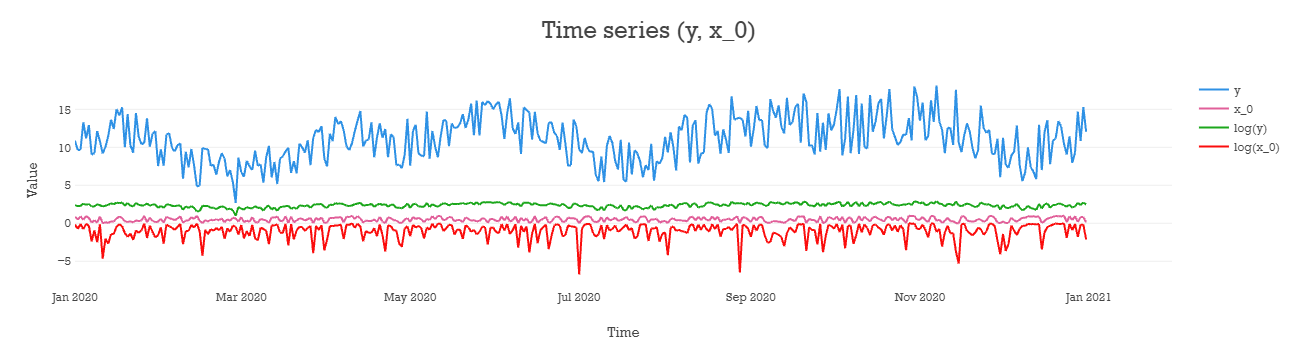

In [13]:
plot_ts(total_df, y_cols=["y", "x_0"], tf="log", tf_args = (np.e,), keep_original=True)

There are other useful transformations, as well as the possibility of passing a custom one.
Here we can see the Box-Cox transform applied to our target series.

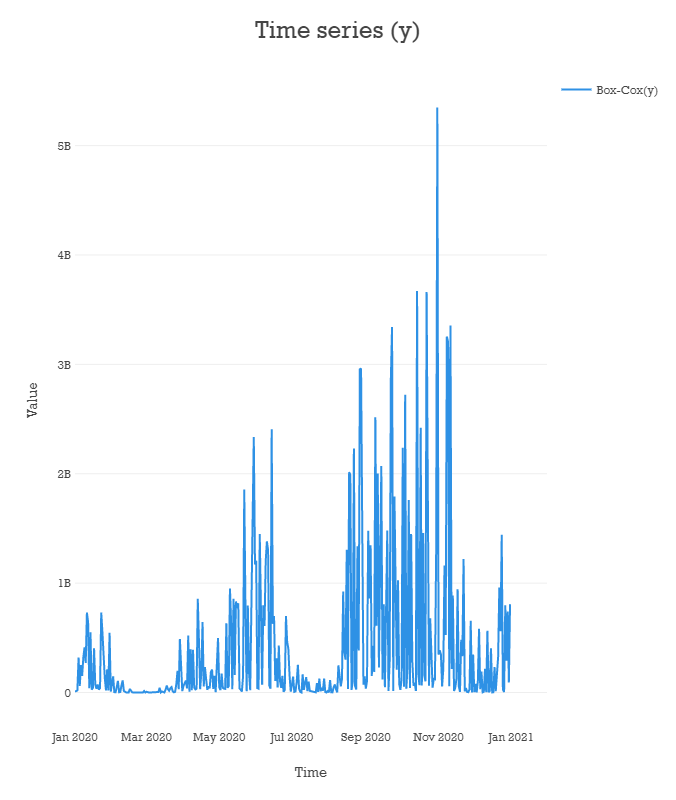

In [49]:
plot_ts(total_df, y_cols=["y"], tf="Box-Cox", keep_original=False)

## Seasonal plot

We can take our target series and inspect it, looking for seasonal components. For example, let's break it down into monthly components.

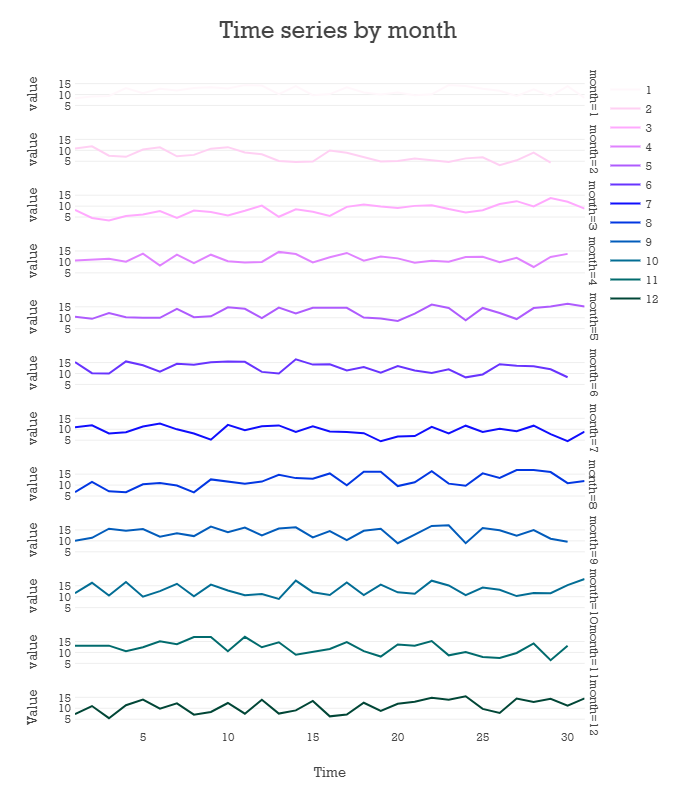

In [16]:
plot_seasonal_ts(ts_df, period="month", subplots=True)

We can also customize the grouping of our data, by specifying a couple of function to pass as period.

These functions are used respectively to assign data points to period groups and to select the granularity with which we want to display the data.

For example, let's say we want to inspect the time series by grouping it into weeks, and keeping a daily granularity:

In [13]:
extract_week = lambda x : x.isocalendar().week
extract_day = lambda x : x.isocalendar().day

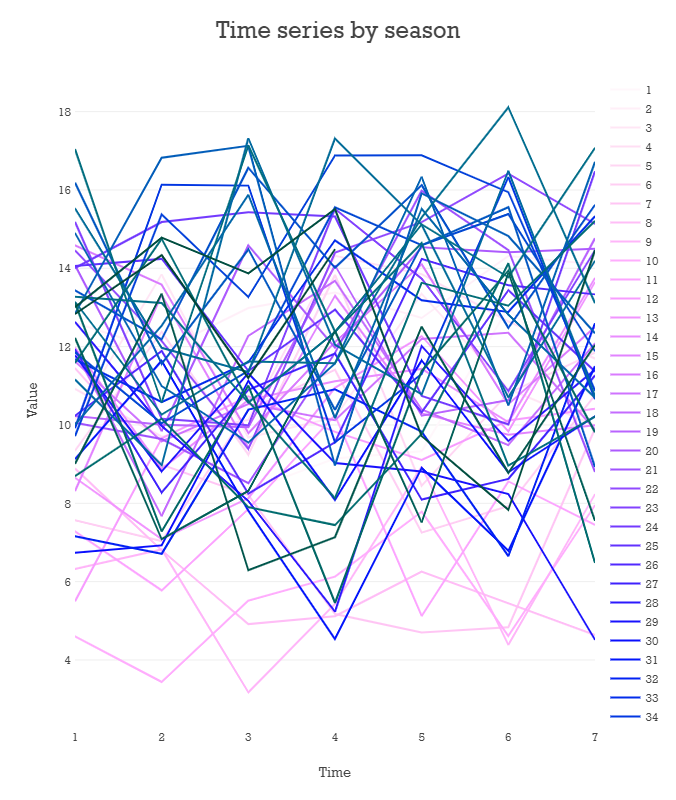

In [18]:
plot_seasonal_ts(ts_df, period=(extract_week, extract_day), subplots=False)

Notice that because of the high number of weeks in our dataset we had to set subplots = False.

## Decomposed plot

One more thing we can do is to try and apply a classic time series decomposition method, such as STL decomposition, to our series:

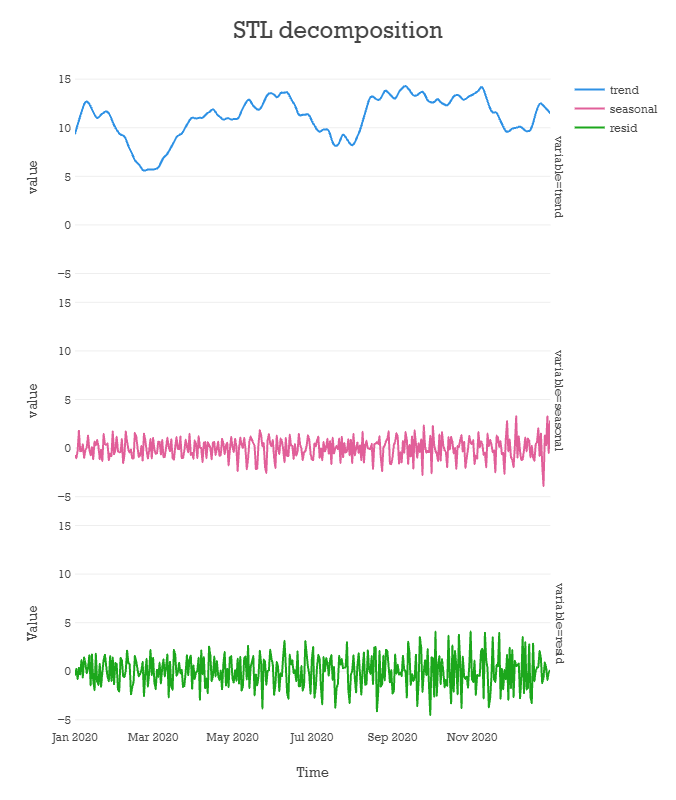

In [19]:
plot_decomposed_ts(ts_df, method = "STL", subplots = True)

## Multiple forecasts

We can display one or more forecasts together with their target series, and also show confidence bounds by specifying their columns in the dataframe.

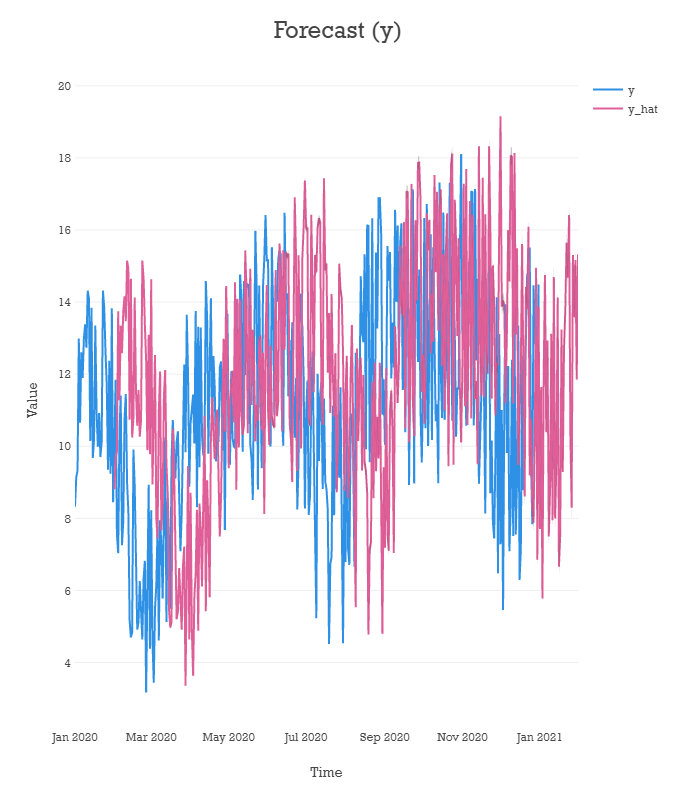

In [23]:
inverted_df = pd.DataFrame(total_df.values[::-1], total_df.index, total_df.columns)

plot_forecast(total_df, y_col = "y", y_hat_cols = ["y_hat"], upper_col = "upper confidence", lower_col = "lower confidence")

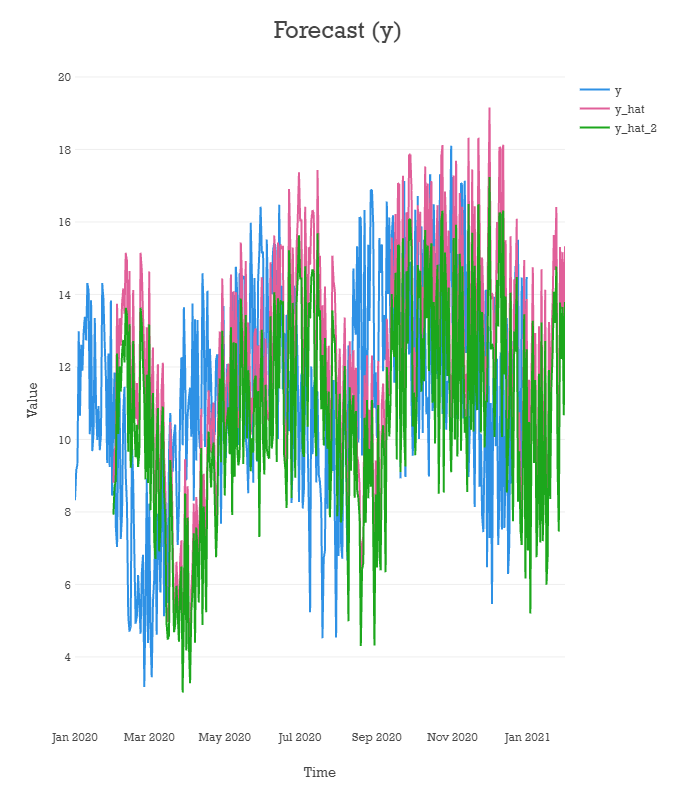

In [24]:
y_hat_2 = pd.Series(data=y_hat*0.9, index = ext_t_axis, name = "y_hat_2")
multiple_fc_df = pd.concat([total_df, y_hat_2], axis = 1)
plot_forecast(multiple_fc_df, y_col = "y", y_hat_cols = ["y_hat", "y_hat_2"])

## Scatter matrix

A useful inspection tool is the scatter matrix, that is a matrix of scatter plots between different series.

We can include features, the target as well as lagged versions of both of them.

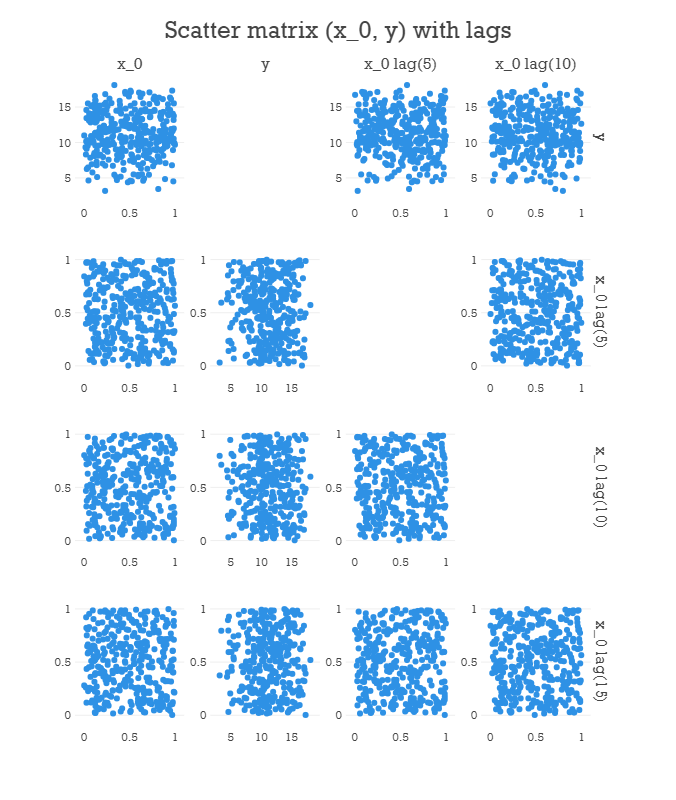

In [25]:
plot_scatter_matrix(total_df, var1 = "x_0", var2="y", lags1 = [5, 10, 15])

## Fit

By inspecting a single pair of time series in a scatter plot we can show the fit line, together with a verbose summary of the fit computation.

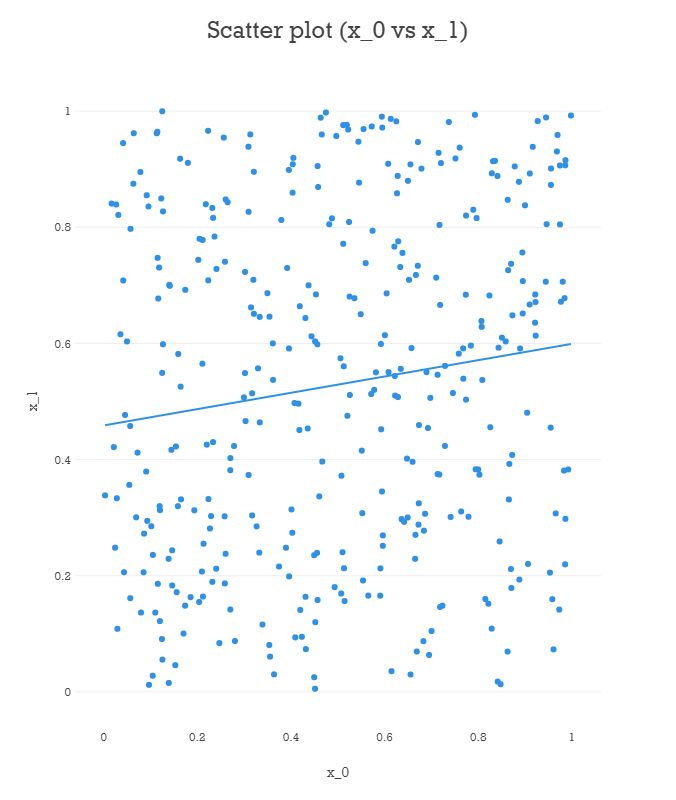

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     7.123
Date:                Wed, 27 Oct 2021   Prob (F-statistic):            0.00795
Time:                        16:01:21   Log-Likelihood:                -63.656
No. Observations:                 366   AIC:                             131.3
Df Residuals:                     364   BIC:                             139.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4588      0.030     15.112      0.0

In [26]:
plot_scatter_fit(total_df, "x_0", "x_1", fit = "summary")

Extra arguments can be passed to modify the fit method of computation, for example:

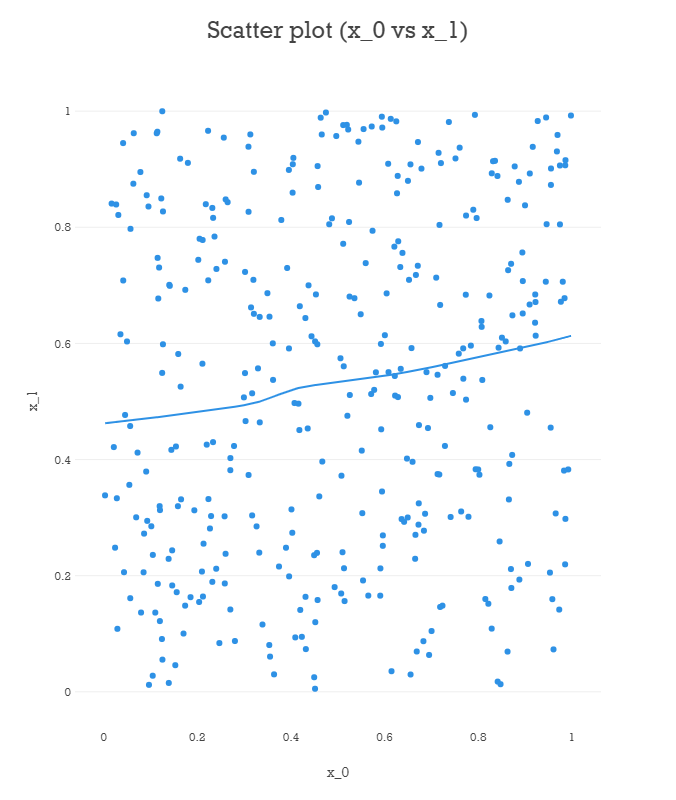

In [32]:
plot_scatter_fit(total_df, "x_0", "x_1",  trendline="lowess")

## Autocorrelation

We can produce autocorrelation (or partial autocorrelation) charts for a given time series, and optionally include both the significance correlation threshold and the confidence intervals for correlation values, to assess any significant lag in the series.

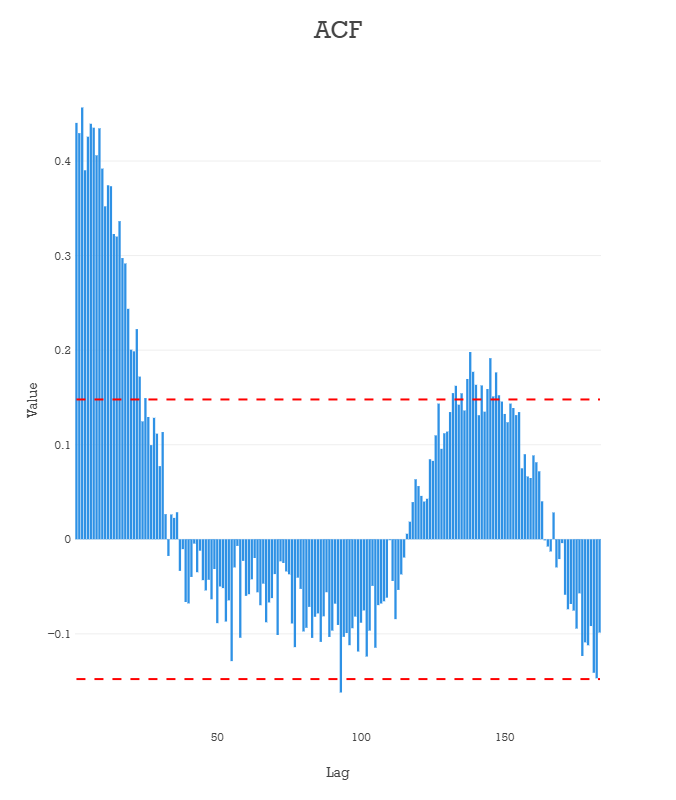

In [33]:
plot_acf(ts_df, show_threshold = True)

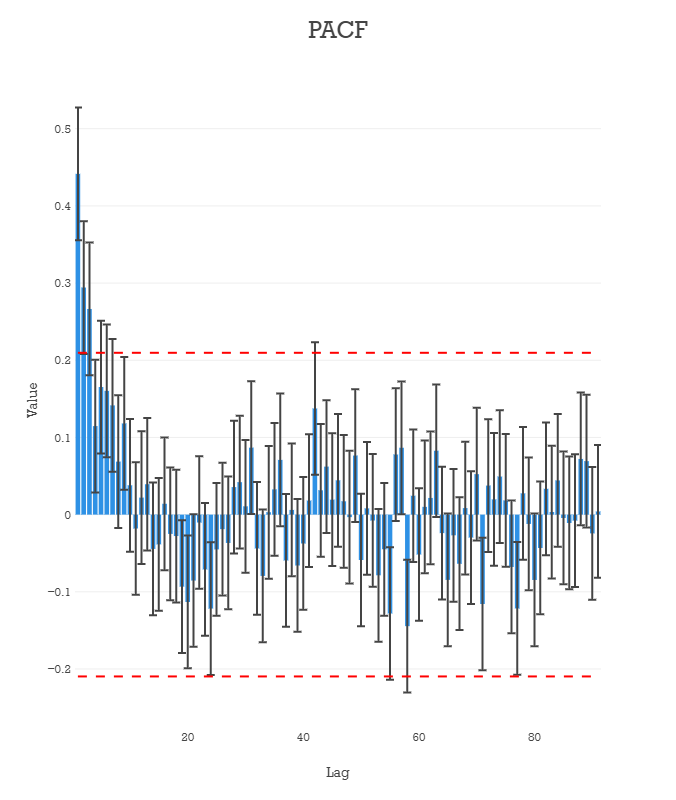

In [34]:
plot_acf(ts_df, partial=True, alpha = 0.1, show_threshold = True)

Another useful tool is the visualization of the distribution and the spectral decomposition of a time series.

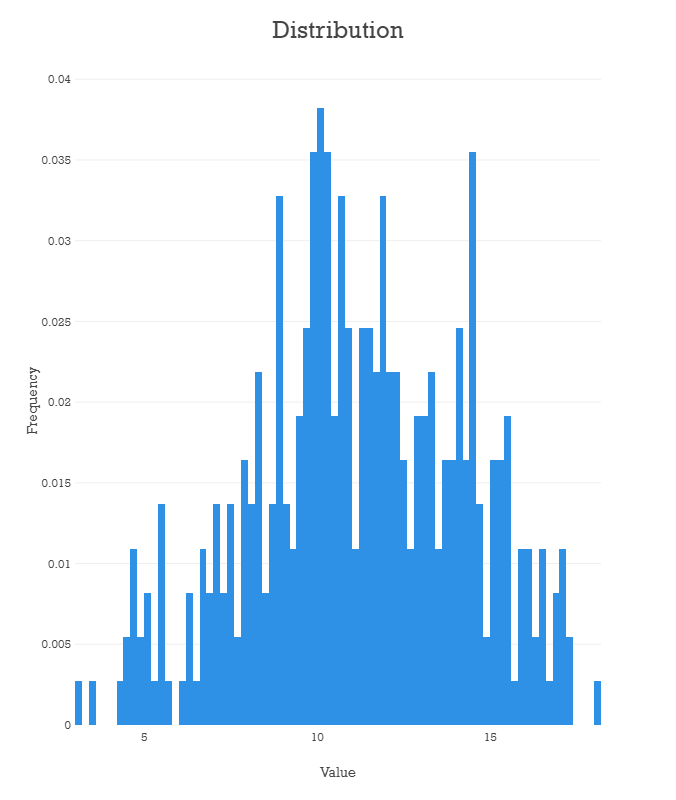

In [36]:
plot_distribution(total_df, bins=100, title="Distribution")

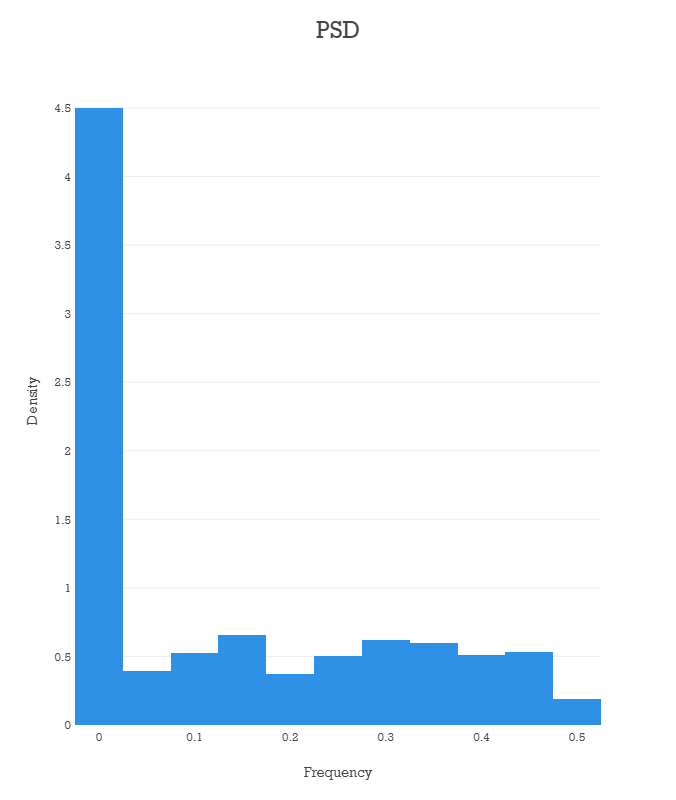

In [35]:
plot_psd(ts_df, scaling="spectrum")

## Roots of an ARMA process

Finally, let's take a look at the roots of a given ARMA process; they can be used to find out is the process is stationary, among other things.

In [37]:
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
arma_process = sm.tsa.ArmaProcess(ar, ma)

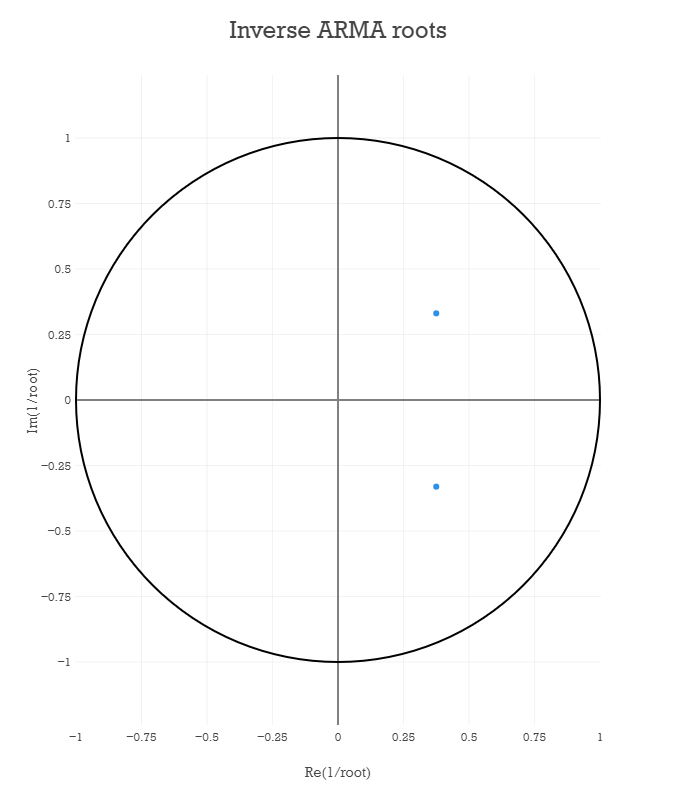

In [38]:
plot_inverse_arma_roots(arma_process)

## Composite visualizations

To conclude, here are some common composite plots that can be produced all at once, in order to provide a comprehensive qualitative view of a (set of) time series.

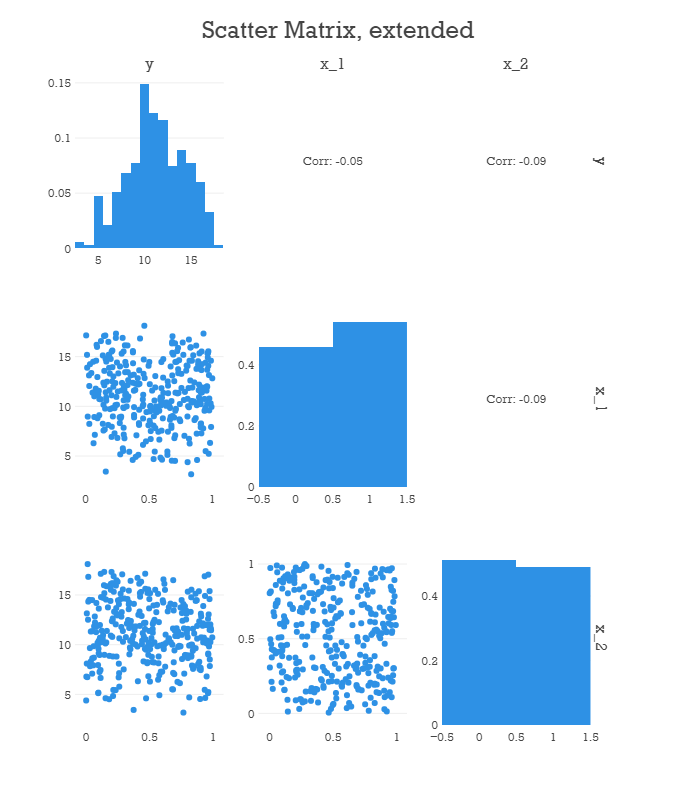

In [39]:
plot_extended_scatter_matrix(total_df.dropna(), y_cols=["y", "x_1", "x_2"])

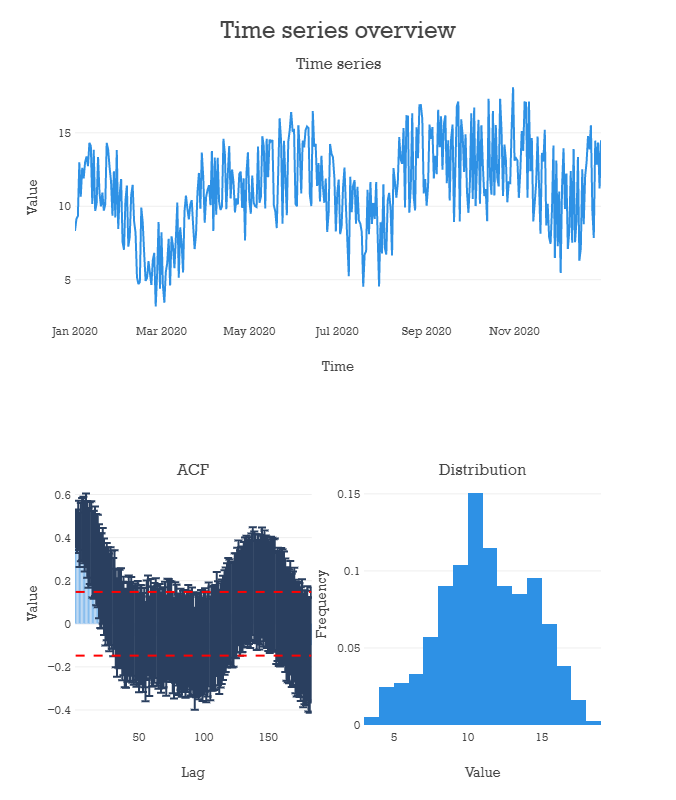

In [40]:
plot_ts_overview(ts_df)

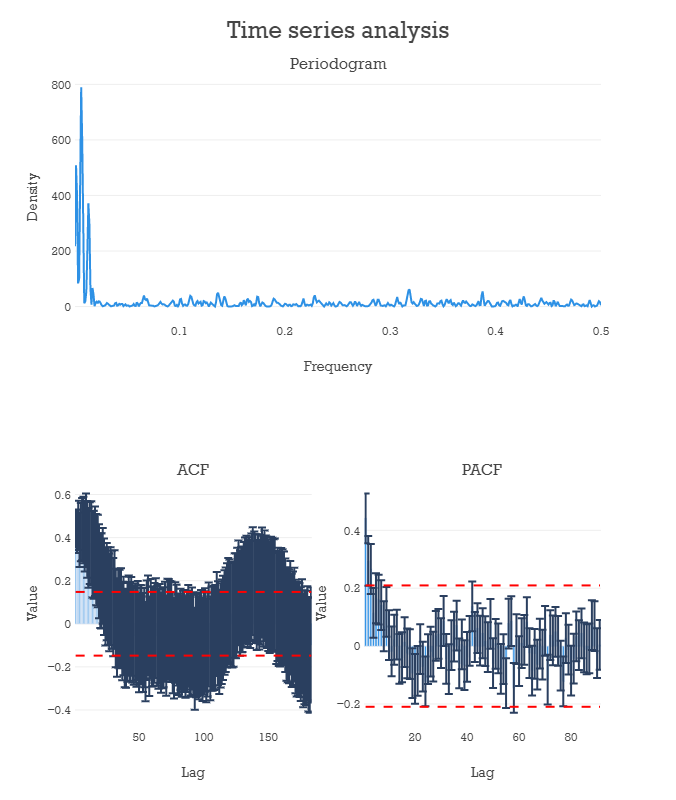

In [41]:
plot_ts_analysis(ts_df)

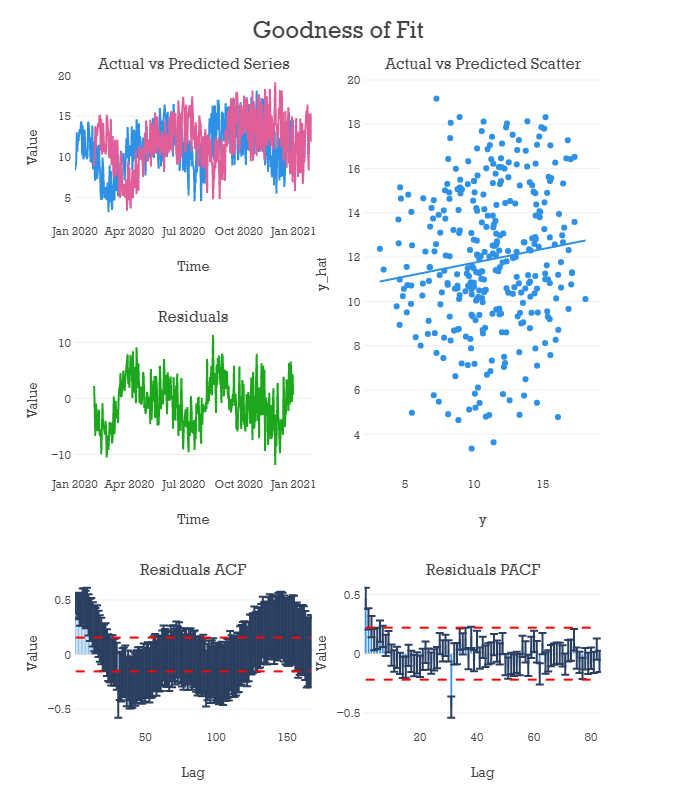

In [42]:
plot_gof(total_df, "y", "y_hat")